In [1]:
import pickle
import xgboost as xgb 
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, ConfusionMatrixDisplay, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import gc

/Users/sid98/OMSA/06_ISYE_6740_CDA/Project/instacart/lib/python3.12/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
FEATURES = [
    "order_number", "last_order_number", "order_dow", "order_hour_of_day", "days_since_prior_order",
    "days_since_prev_order_item", ## Current order Features

    "total_orders_uxp", "usual_cart_position_uxp", "streak_chance_uxp", "item_n2_chance_uxp", "item_n3_chance_uxp", 
    "item_n4_chance_uxp", "item_n5_chance_uxp", "average_reorder_time_uxp", ## Uxp Features

    "reorder_ratio_product", "total_purchases_product", "usual_position_in_cart_product", "avg_cart_size_product",
    "usual_buying_time_product", "usual_buying_day_product", "one_shot_ratio_product", "unique_users_product", ## Prod Features

    "total_orders_user", "avg_time_between_orders_user", "usual_buying_time_user", "usual_buying_day_user", "total_unique_products_bought_user",
    "first_product_reordered_user", "complete_new_order_user", "average_product_per_order_user", "average_reorder_ratio_per_order_user", ## User Features
]

In [3]:
with open("../FeatureStore/TrainingDataset_AllOrders.pickle", "rb") as file:
    trainingDataset = pickle.load(file)

with open("../FeatureStore/TestDataset_AllOrders.pickle", "rb") as file:
    testDataset = pickle.load(file)

In [6]:
trainingDataset.head()

,user_id,product_id,order_number,last_order_number,order_dow,order_hour_of_day,days_since_prior_order,days_since_prev_order_item,products_ordered_in_this_order,total_orders_uxp,...,total_orders_user,avg_time_between_orders_user,usual_buying_time_user,usual_buying_day_user,total_unique_products_bought_user,first_product_reordered_user,complete_new_order_user,average_product_per_order_user,average_reorder_ratio_per_order_user,reordered
0,1,196,9,8.0,1,16,0.0,0.0,0.0,8,...,8,21.128205,9.0,3.0,15,1.0,0.0,5.0,0.770238,1.0
1,1,10258,9,8.0,1,16,0.0,0.0,0.0,7,...,8,21.128205,9.0,3.0,15,1.0,0.0,5.0,0.770238,1.0
2,1,10326,9,5.0,1,16,0.0,53.0,0.0,1,...,8,21.128205,9.0,3.0,15,1.0,0.0,5.0,0.770238,0.0
3,1,12427,9,8.0,1,16,0.0,0.0,0.0,8,...,8,21.128205,9.0,3.0,15,1.0,0.0,5.0,0.770238,1.0
4,1,13032,9,7.0,1,16,0.0,14.0,0.0,2,...,8,21.128205,9.0,3.0,15,1.0,0.0,5.0,0.770238,0.0


In [7]:
userDataset = trainingDataset[["user_id", "order_number", "last_order_number", "order_dow", "order_hour_of_day", "days_since_prior_order",
    "days_since_prev_order_item", "total_orders_user", "avg_time_between_orders_user", "usual_buying_time_user", "usual_buying_day_user", "total_unique_products_bought_user",
    "first_product_reordered_user", "complete_new_order_user", "average_product_per_order_user", "average_reorder_ratio_per_order_user"]].drop_duplicates(subset=["user_id"]).reset_index(drop=True)

In [14]:
X = userDataset[["order_number", "last_order_number", "order_dow", "order_hour_of_day", "days_since_prior_order",
    "days_since_prev_order_item", "total_orders_user", "avg_time_between_orders_user", "usual_buying_time_user", "usual_buying_day_user", "total_unique_products_bought_user",
    "first_product_reordered_user", "complete_new_order_user", "average_product_per_order_user"]]
y = userDataset["average_reorder_ratio_per_order_user"]

from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
model.fit(X,y)

In [9]:
y_pred = model.predict(X)

In [13]:
y

0.7515654418332983

In [15]:
import numpy as np 
error = 0
for ytrue,ypred in zip(y, y_pred):
    error += (np.log(ytrue+1) - np.log(ypred+1))**2
rmsle = np.sqrt(error/len(y))
rmsle

0.027488301395764914

In [17]:
y.mean()

0.4806228413396748

In [18]:
0.02/0.48

0.04166666666666667

In [6]:
del trainingDataset, testDataset
gc.collect()

40

In [8]:
model = lgb.LGBMClassifier()
model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 1212711, number of negative: 10454486
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.943458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4601
[LightGBM] [Info] Number of data points in the train set: 11667197, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.103942 -> initscore=-2.154173
[LightGBM] [Info] Start training from score -2.154173


LGBMClassifier()

In [10]:
y_pred = model.predict(X_train)

In [11]:
y_pred_proba = model.predict_proba(X_train)[:, 1]

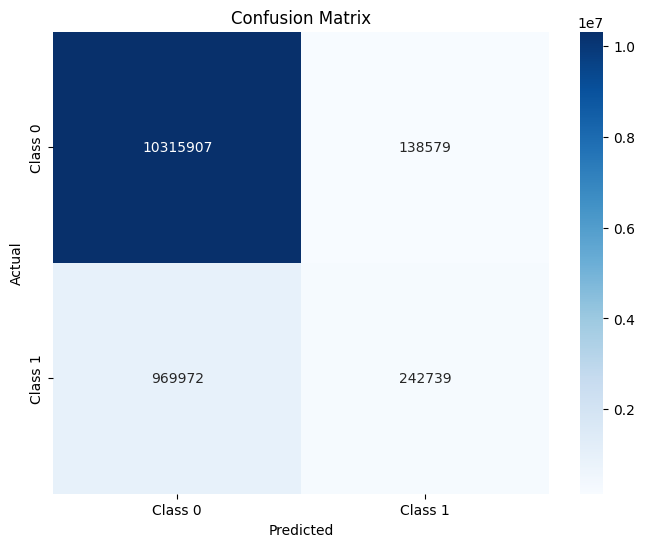

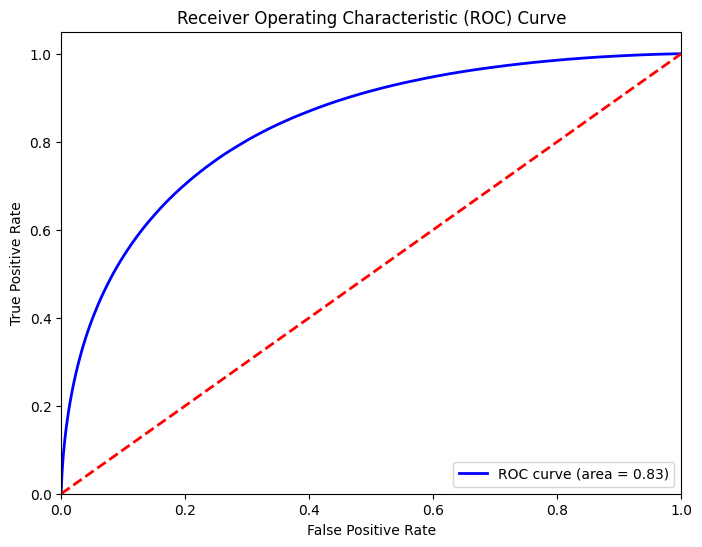

In [13]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_train, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_train, y_pred_proba)
roc_auc = roc_auc_score(y_train, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [14]:
f1_score(y_train, y_pred)

0.30456033108556996

In [ ]:
t

In [15]:
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Minimal hyperparameter tuning using GridSearchCV
param_grid = {
    'num_leaves': [31, 61],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200]
}
# set lower num_boost_round (I used 300 instead of 50 at home) to avoid time-out on Kaggle

model = lgb.LGBMClassifier(boosting_type='gbdt', objective='binary')
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1', cv=3)
grid_search.fit(X_train, y_train)

# Best model from GridSearchCV
best_model = grid_search.best_estimator_

[LightGBM] [Info] Number of positive: 808474, number of negative: 6969657
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.487953 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4581
[LightGBM] [Info] Number of data points in the train set: 7778131, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.103942 -> initscore=-2.154173
[LightGBM] [Info] Start training from score -2.154173
[LightGBM] [Info] Number of positive: 808474, number of negative: 6969657
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.467817 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4582
[LightGBM] [Info] Number of data points in the train set: 7778131, number of used features: 31
[LightGB

KeyboardInterrupt: 

In [ ]:
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_val)
f1 = f1_score(y_test, y_pred)

